::: {.callout-note collapse="false"}
## Learning Outcomes
* Understand what models are and how to carry out the four-step modeling process.
* Define the concept of loss and gain familiarity with $L_1$ and $L_2$ loss.
* Fit the Simple Linear Regression model using minimization techniques.
:::

Up until this point in the semester, we've focused on analyzing datasets. We've looked into the early stages of the data science lifecycle, focusing on the programming tools, visualization techniques, and data cleaning methods needed for data analysis.

This lecture marks a shift in focus. We will move away from examining datasets to actually *using* our data to better understand the world. Specifically, the next sequence of lectures will explore predictive modeling: generating models to make some predictions about the world around us. In this lecture, we'll introduce the conceptual framework for setting up a modeling task. In the next few lectures, we'll put this framework into practice by implementing various kinds of models.

## What is a Model?

A model is an **idealized representation** of a system. A system is a set of principles or procedures according to which something functions. We live in a world full of systems: the procedure of turning on a light happens according to a specific set of rules dictating the flow of electricity. The truth behind how any event occurs is usually complex, and many times the specifics are unknown. The workings of the world can be viewed as its own giant procedure. Models seek to simplify the world and distill them into workable pieces.  

Example:
We model the fall of an object on Earth as subject to a constant acceleration of $9.81 m/s^2$ due to gravity.

- While this describes the behavior of our system, it is merely an approximation.
- It doesn’t account for the effects of air resistance, local variations in gravity, etc.
- In practice, it’s accurate enough to be useful!

### Reasons for Building Models

Why do we want to build models? As far as data scientists and statisticians are concerned, there are three reasons, and each implies a different focus on modeling.

1. To explain complex phenomena occurring in the world we live in. Examples of this might be:

    - How are the parents' average height related to their children's average height?
    - How does an object’s velocity and acceleration impact how far it travels? (Physics: $d = d_0 + vt + \frac{1}{2}at^2$) 
    
    In these cases, we care about creating models that are *simple and interpretable*, allowing us to understand what the relationships between our variables are.

2. To make accurate predictions about unseen data. Some examples include:

    - Can we predict if an email is spam or not?
    - Can we generate a one-sentence summary of this 10-page long article?

    When making predictions, we care more about making extremely accurate predictions, at the cost of having an uninterpretable model. These are sometimes called black-box models and are common in fields like deep learning.

3. To measure the causal effects of one event on some other event. For example,
   
    - Does smoking *cause* lung cancer?
    - Does a job training program *cause* increases in employment and wages?

    This is a much harder question because most statistical tools are designed to infer association, not causation. We will not focus on this task in Data 100, but you can take other advanced classes on causal inference (e.g., Stat 156, Data 102) if you are intrigued! 

Most of the time, we aim to strike a balance between building **interpretable** models and building **accurate models**.


### Common Types of Models

In general, models can be split into two categories:

1. Deterministic physical (mechanistic) models: Laws that govern how the world works.

    - [Kepler's Third Law of Planetary Motion (1619)](https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion#Third_law): The ratio of the square of an object's orbital period with the cube of the semi-major axis of its orbit is the same for all objects orbiting the same primary.
        - $T^2 \propto R^3$

    - [Newton's Laws: motion and gravitation (1687)](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion): Newton’s second law of motion models the relationship between the mass of an object and the force required to accelerate it.
        - $F = ma$
        - $F_g = G \frac{m_1 m_2}{r^2}$
<br>

2. Probabilistic models: Models that attempt to understand how random processes evolve. These are more general and can be used to describe many phenomena in the real world. These models commonly make simplifying assumptions about the nature of the world.

    - [Poisson Process models](https://en.wikipedia.org/wiki/Poisson_point_process): Used to model random events that happen with some probability at any point in time and are strictly increasing in count, such as the arrival of customers at a store. 

Note: These specific models are not in the scope of Data 100 and exist to serve as motivation.

## Simple Linear Regression 

The **regression line** is the unique straight line that minimizes the **mean squared error** of estimation among all straight lines. As with any straight line, it can be defined by a slope and a y-intercept:

- $slope = r \cdot \frac{\text{Standard Deviation of } y}{\text{Standard Deviation of }x}$
- $y\text{-intercept} = \text{average of }y - \text{slope}\cdot\text{average of }x$
- $\text{regression estimate} = y\text{-intercept} + \text{slope}\cdot\text{}x$
- $\text{residual} =\text{observed }y - \text{regression estimate}$

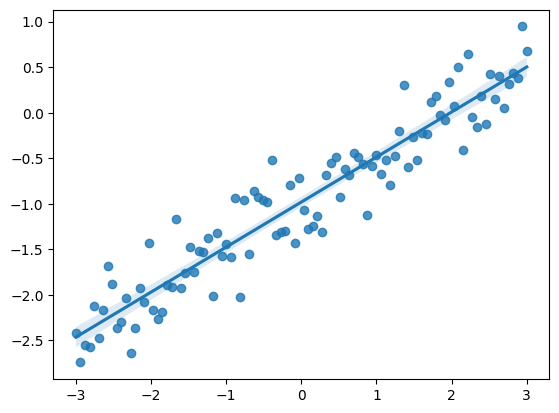

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set random seed for consistency 
np.random.seed(43)
plt.style.use('default') 

#Generate random noise for plotting
x = np.linspace(-3, 3, 100)
y = x * 0.5 - 1 + np.random.randn(100) * 0.3

#plot regression line
sns.regplot(x=x,y=y);

### Notations and Definitions

For a pair of variables $x$ and $y$ representing our data $\mathcal{D} = \{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}$, we denote their means/averages as $\bar x$ and $\bar y$ and standard deviations as $\sigma_x$ and $\sigma_y$.

#### Standard Units
A variable is represented in standard units if the following are true:

1. 0 in standard units is equal to the mean ($\bar{x}$) in the original variable's units.
2. An increase of 1 standard unit is an increase of 1 standard deviation ($\sigma_x$) in the original variable's units.

To convert a variable $x_i$ into standard units, we subtract its mean from it and divide it by its standard deviation. For example, $x_i$ in standard units is $\frac{x_i - \bar x}{\sigma_x}$.

#### Correlation

The correlation ($r$) is the average of the product of $x$ and $y$, both measured in *standard units*.

$$r = \frac{1}{n} \sum_{i=1}^n (\frac{x_i - \bar{x}}{\sigma_x})(\frac{y_i - \bar{y}}{\sigma_y})$$

1. Correlation measures the strength of a **linear association** between two variables.
2. Correlations range between -1 and 1: $|r| \leq 1$, with $r=1$ indicating perfect linear association, and $r=-1$ indicating perfect negative association. The closer $r$ is to $0$, the weaker the linear association is.
3. Correlation says nothing about causation and non-linear association. Correlation does imply causation. When $r = 0$, the two variables are uncorrelated. However, they could still be related through some non-linear relationship.

In [1]:
def plot_and_get_corr(ax, x, y, title):
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x, y, alpha = 0.73)
    r = np.corrcoef(x, y)[0, 1]
    ax.set_title(title + " (corr: {})".format(r.round(2)))
    return r

fig, axs = plt.subplots(2, 2, figsize = (10, 10))

# Just noise
x1, y1 = np.random.randn(2, 100)
corr1 = plot_and_get_corr(axs[0, 0], x1, y1, title = "noise")

# Strong linear
x2 = np.linspace(-3, 3, 100)
y2 = x2 * 0.5 - 1 + np.random.randn(100) * 0.3
corr2 = plot_and_get_corr(axs[0, 1], x2, y2, title = "strong linear")

# Unequal spread
x3 = np.linspace(-3, 3, 100)
y3 = - x3/3 + np.random.randn(100)*(x3)/2.5
corr3 = plot_and_get_corr(axs[1, 0], x3, y3, title = "strong linear")
extent = axs[1, 0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Strong non-linear
x4 = np.linspace(-3, 3, 100)
y4 = 2*np.sin(x3 - 1.5) + np.random.randn(100) * 0.3
corr4 = plot_and_get_corr(axs[1, 1], x4, y4, title = "strong non-linear")

plt.show()

NameError: name 'plt' is not defined

### Alternate Form
When the variables $y$ and $x$ are measured in *standard units*, the regression line for predicting $y$ based on $x$ has slope $r$ and passes through the origin.

 $$\hat{y}_{su} = r \cdot x_{su}$$


<div style="text-align: center;"><img src = "./images/reg_line_suu.png"></img></div>


- In the original units, this becomes

$$\frac{\hat{y} - \bar{y}}{\sigma_y} = r \cdot \frac{x - \bar{x}}{\sigma_x}$$

<div style="text-align: center;"><img src = "./images/reg_line_ou.png"></img></div>

### Derivation

Starting from the top, we have our claimed form of the regression line, and we want to show that it is equivalent to the optimal linear regression line: $\hat{y} = \hat{a} + \hat{b}x$

Recall: 

- $\hat{b} = r \cdot \frac{\text{Standard Deviation of }y}{\text{Standard Deviation of }x}$
- $\hat{a} = \text{average of }y - \text{slope}\cdot\text{average of }x$

:::{.callout}

Proof: 

$$\frac{\hat{y} - \bar{y}}{\sigma_y} = r \cdot \frac{x - \bar{x}}{\sigma_x}$$

Multiply by $\sigma_y$, and add $\bar{y}$ on both sides.

$$\hat{y} = \sigma_y \cdot r \cdot \frac{x - \bar{x}}{\sigma_x} + \bar{y}$$

Distribute coefficient $\sigma_{y}\cdot r$ to the $\frac{x - \bar{x}}{\sigma_x}$ term

$$\hat{y} = (\frac{r\sigma_y}{\sigma_x} ) \cdot x + (\bar{y} - (\frac{r\sigma_y}{\sigma_x} ) \bar{x})$$

We now see that we have a line that matches our claim:

- slope: $r\cdot\frac{\text{SD of x}}{\text{SD of y}} = r\cdot\frac{\sigma_x}{\sigma_y}$
- intercept: $\bar{y} - \text{slope}\cdot x$

Note that the error for the i-th datapoint is: $e_i = y_i - \hat{y_i}$

:::


## The Modeling Process

At a high level, a model is a way of representing a system. In Data 100, we'll treat a model as some mathematical rule we use to describe the relationship between variables. 

What variables are we modeling? Typically, we use a subset of the variables in our sample of collected data to model another variable in this data. To put this more formally, say we have the following dataset $\mathcal{D}$:

$$\mathcal{D} = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$$

Each pair of values $(x_i, y_i)$ represents a datapoint. In a modeling setting, we call these **observations**. $y_i$ is the dependent variable we are trying to model, also called an **output** or **response**. $x_i$ is the independent variable inputted into the model to make predictions, also known as a **feature**. 

Our goal in modeling is to use the observed data $\mathcal{D}$ to predict the output variable $y_i$. We denote each prediction as $\hat{y}_i$ (read: "y hat sub i").

How do we generate these predictions? Some examples of models we'll encounter in the next few lectures are given below:

$$\hat{y}_i = \theta$$
$$\hat{y}_i = \theta_0 + \theta_1 x_i$$

The examples above are known as **parametric models**. They relate the collected data, $x_i$, to the prediction we make, $\hat{y}_i$. A few parameters ($\theta$, $\theta_0$, $\theta_1$) are used to describe the relationship between $x_i$ and $\hat{y}_i$.

Notice that we don't immediately know the values of these parameters. While the features, $x_i$, are taken from our observed data, we need to decide what values to give $\theta$, $\theta_0$, and $\theta_1$ ourselves. This is the heart of parametric modeling: *what parameter values should we choose so our model makes the best possible predictions?*

To choose our model parameters, we'll work through the **modeling process**. 

1. Choose a model: how should we represent the world?
2. Choose a loss function: how do we quantify prediction error?
3. Fit the model: how do we choose the best parameters of our model given our data?
4. Evaluate model performance: how do we evaluate whether this process gave rise to a good model?

## Choosing a Model

Our first step is choosing a model: defining the mathematical rule that describes the relationship between the features, $x_i$, and predictions $\hat{y}_i$. 

In [Data 8](https://inferentialthinking.com/chapters/15/4/Least_Squares_Regression.html), you learned about the **Simple Linear Regression (SLR) model**. You learned that the model takes the form:
$$\hat{y}_i = a + bx_i$$

In Data 100, we'll use slightly different notation: we will replace $a$ with $\theta_0$ and $b$ with $\theta_1$. This will allow us to use the same notation when we explore more complex models later on in the course.

$$\hat{y}_i = \theta_0 + \theta_1 x_i$$

The parameters of the SLR model are $\theta_0$, also called the intercept term, and $\theta_1$, also called the slope term. To create an effective model, we want to choose values for $\theta_0$ and $\theta_1$ that most accurately predict the output variable. The "best" fitting model parameters are given the special names: $\hat{\theta}_0$ and $\hat{\theta}_1$; they are the specific parameter values that allow our model to generate the best possible predictions.

In Data 8, you learned that the best SLR model parameters are:
$$\hat{\theta}_0 = \bar{y} - \hat{\theta}_1\bar{x} \qquad \qquad \hat{\theta}_1 = r \frac{\sigma_y}{\sigma_x}$$

A quick reminder on notation:

* $\bar{y}$ and $\bar{x}$ indicate the mean value of $y$ and $x$, respectively
* $\sigma_y$ and $\sigma_x$ indicate the standard deviations of $y$ and $x$
* $r$ is the [correlation coefficient](https://inferentialthinking.com/chapters/15/1/Correlation.html#the-correlation-coefficient), defined as the average of the product of $x$ and $y$ measured in standard units: $\frac{1}{n} \sum_{i=1}^n (\frac{x_i-\bar{x}}{\sigma_x})(\frac{y_i-\bar{y}}{\sigma_y})$

In Data 100, we want to understand *how* to derive these best model coefficients. To do so, we'll introduce the concept of a loss function.

## Choosing a Loss Function

We've talked about the idea of creating the "best" possible predictions. This begs the question: how do we decide how "good" or "bad" our model's predictions are?

A **loss function** characterizes the cost, error, or fit resulting from a particular choice of model or model parameters. This function, $L(y, \hat{y})$, quantifies how "bad" or "far off" a single prediction by our model is from a true, observed value in our collected data. 

The choice of loss function for a particular model will affect the accuracy and computational cost of estimation, and it'll also depend on the estimation task at hand. For example, 

* Are outputs quantitative or qualitative? 
* Do outliers matter? 
* Are all errors equally costly? (e.g., a false negative on a cancer test is arguably more dangerous than a false positive) 

Regardless of the specific function used, a loss function should follow two basic principles:

* If the prediction $\hat{y}_i$ is *close* to the actual value $y_i$, loss should be low.
* If the prediction $\hat{y}_i$ is *far* from the actual value $y_i$, loss should be high.

Two common choices of loss function are squared loss and absolute loss. 

**Squared loss**, also known as **L2 loss**, computes loss as the square of the difference between the observed $y_i$ and predicted $\hat{y}_i$:
$$L(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2$$

**Absolute loss**, also known as **L1 loss**, computes loss as the absolute difference between the observed $y_i$ and predicted $\hat{y}_i$:
$$L(y_i, \hat{y}_i) = |y_i - \hat{y}_i|$$

L1 and L2 loss give us a tool for quantifying our model's performance on a single data point. This is a good start, but ideally, we want to understand how our model performs across our *entire* dataset. A natural way to do this is to compute the average loss across all data points in the dataset. This is known as the **cost function**, $\hat{R}(\theta)$:
$$\hat{R}(\theta) = \frac{1}{n} \sum^n_{i=1} L(y_i, \hat{y}_i)$$

The cost function has many names in the statistics literature. You may also encounter the terms:

* Empirical risk (this is why we give the cost function the name $R$)
* Error function
* Average loss

We can substitute our L1 and L2 loss into the cost function definition. The **Mean Squared Error (MSE)** is the average squared loss across a dataset:
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

The **Mean Absolute Error (MAE)** is the average absolute loss across a dataset:
$$\text{MAE}= \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|$$

## Fitting the Model

Now that we've established the concept of a loss function, we can return to our original goal of choosing model parameters. Specifically, we want to choose the best set of model parameters that will minimize the model's cost on our dataset. This process is called fitting the model.

We know from calculus that a function is minimized when (1) its first derivative is equal to zero and (2) its second derivative is positive. We often call the function being minimized the **objective function** (our objective is to find its minimum).

To find the optimal model parameter, we:

1. Take the derivative of the cost function with respect to that parameter
2. Set the derivative equal to 0
3. Solve for the parameter

We repeat this process for each parameter present in the model. For now, we'll disregard the second derivative condition. 

To help us make sense of this process, let's put it into action by deriving the optimal model parameters for simple linear regression using the mean squared error as our cost function. Remember: although the notation may look tricky, all we are doing is following the three steps above!

Step 1: take the derivative of the cost function with respect to each model parameter. We substitute the SLR model, $\hat{y}_i = \theta_0+\theta_1 x_i$, into the definition of MSE above and differentiate with respect to $\theta_0$ and $\theta_1$.
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^{n} (y_i - \theta_0 - \theta_1 x_i)^2$$

$$\frac{\partial}{\partial \theta_0} \text{MSE} = \frac{-2}{n} \sum_{i=1}^{n} y_i - \theta_0 - \theta_1 x_i$$

$$\frac{\partial}{\partial \theta_1} \text{MSE} = \frac{-2}{n} \sum_{i=1}^{n} (y_i - \theta_0 - \theta_1 x_i)x_i$$

Step 2: set the derivatives equal to 0. After simplifying terms, this produces two **estimating equations**. The best set of model parameters $(\hat{\theta}_0, \hat{\theta}_1)$ *must* satisfy these two optimality conditions.
$$0 = \frac{-2}{n} \sum_{i=1}^{n} y_i - \hat{\theta}_0 - \hat{\theta}_1 x_i \Longleftrightarrow \frac{1}{n}\sum_{i=1}^{n} y_i - \hat{y}_i = 0$$
$$0 = \frac{-2}{n} \sum_{i=1}^{n} (y_i - \hat{\theta}_0 - \hat{\theta}_1 x_i)x_i \Longleftrightarrow \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)x_i = 0$$

Step 3: solve the estimating equations to compute estimates for $\hat{\theta}_0$ and $\hat{\theta}_1$.

Taking the first equation gives the estimate of $\hat{\theta}_0$:
$$
\frac{1}{n} \sum_{i=1}^n y_i - \hat{\theta}_0 - \hat{\theta}_1 x_i = 0 \\
\left(\frac{1}{n} \sum_{i=1}^n y_i \right) - \hat{\theta}_0 - \hat{\theta}_1\left(\frac{1}{n} \sum_{i=1}^n x_i \right) = 0 \\
\hat{\theta}_0 = \bar{y} - \hat{\theta}_1 \bar{x}
$$

With a bit more maneuvering, the second equation gives the estimate of $\hat{\theta}_1$. Start by multiplying the first estimating equation by $\bar{x}$, then subtracting the result from the second estimating equation.
$$
\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)x_i - \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)\bar{x} = 0 \\
\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)(x_i - \bar{x}) = 0
$$

Next, plug in $\hat{y}_i = \hat{\theta}_0 + \hat{\theta}_1 x_i = \bar{y} + \hat{\theta}_1(x_i - \bar{x})$:
$$
\frac{1}{n} \sum_{i=1}^n (y_i - \bar{y} - \hat{\theta}_1(x - \bar{x}))(x_i - \bar{x}) = 0 \\
\frac{1}{n} \sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) = \hat{\theta}_1 \times \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2
$$

By using the definition of correlation $\left(r = \frac{1}{n} \sum_{i=1}^n (\frac{x_i-\bar{x}}{\sigma_x})(\frac{y_i-\bar{y}}{\sigma_y}) \right)$ and standard deviation $\left(\sigma_x = \sqrt{\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2} \right)$, we can conclude:
$$r \sigma_x \sigma_y = \hat{\theta}_1 \times \sigma_x^2$$
$$\hat{\theta}_1 = r \frac{\sigma_y}{\sigma_x}$$

Just as was given in Data 8! 

Remember, this derivation found the optimal model parameters for SLR when using the MSE cost function. If we had used a different model or different loss function, we likely would have found different values for the best model parameters. However, regardless of the model and loss used, we can *always* follow these three steps to fit the model.